<a href="https://colab.research.google.com/github/nechebarrena/HOML/blob/main/HOML_cap_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAPITULO 3 - HANDS ON MACHINE LEARNING
## CLASIFICADORES
En este archivo se encuentran los ejemplos propuestos en el capitulo y algunas anotaciones tomadas del mismo.

En este capitulo el libro muestra como implementar un sistema clasificador y las metricas adecuadas para su evaluacion. El problema que plantea es la clasificacion de imagenes con digitos escritos a mano. Para eso usa el dataset de entrenamoiento MNIST que podemos bajar directamente de Sklearn.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784",version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
import os
from google.colab import drive
#drive.mount("/content/drive")
#os.chdir('drive/My Drive/Colab Notebooks/HOML')
#print(os.listdir())

In [ ]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

str

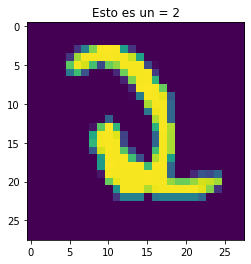

In [ ]:
import matplotlib.pyplot as plt
X = mnist['data']
y = mnist['target']
N = 400
digito_prueba = X[N]
digito_prueba_imagen = digito_prueba.reshape(28,28)
plt.imshow(digito_prueba_imagen)
plt.title('Esto es un = ' + y[N])
type(y[N])

Un poco choto que el target sea un str en lugar de un valor numerico .. =(

Text(0.5, 1.0, 'Distribucion de digitos')

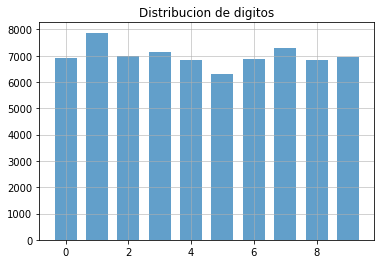

In [ ]:
import numpy as np
y_num = y.astype(np.uint8)

hist_max,bin_edges = np.histogram(y_num, bins=10, range=(0, 10))
plt.bar(bin_edges[:-1], hist_max, width = 0.7,alpha=0.7,label='Digitos')
plt.grid(axis="both", alpha=0.7)
plt.title('Distribucion de digitos')


El libro dice que los datos ya estan separados en train y test, siendo los primeros 60K train y los ultimos 10k test. Sin mebargo al probar graficar el histograma para distintos conjuntos no se ve que esten ordenados. O sea, los datos estan ordenados aleatoriamente, con lo cual uno podria separar en train y test a partir del valor que quiera y no necesariamente en 60k.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y_num[:60000], y_num[60000:]

## Clasificador binario
Antes de abordar el problema el libro propone implementar un clasificador binario, o sea, que puede distinguir entre 2 clases. Por ejemplo, entre aquellos digitos que son 5 y todos los que no lo son. Primero entonces vamos a probar armar este clasificador binario.

array([False,  True, False, ...,  True, False, False])

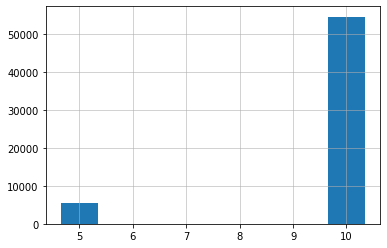

In [ ]:
y_train_5 = (y_train == 5)

y_test_5 = (y_test == 5)

bines = [5,10]
hist = [np.count_nonzero(y_train_5 == True),np.count_nonzero(y_train_5 == False)]
plt.grid(axis="both", alpha=0.7)
plt.bar(bines, hist, width = 0.7,label='Digitos')

y_train_5[10:]

Es evidente que las clases que pretendemos clasificar estan muy desbalanceadas. A pesar de esto vamos a implementar un clasificador y ver que pasa. El libro propone primero implementar un clasificador utilizando el modelo de Descenso estocastico de gradiente (SGD por sus siglas en ingles). 

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Ahora el libro propone hacer una validacion cruzada para poder calcular alguna metrica sobre el clasificador. Sin embargo propone no utilizar la funcion de sklearn ya implementada sino crear una por nosotros mismos.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def val_cruzada_score(k,modelo,X,y):
  X_train = X
  y_train_5 = y
  skfolds = StratifiedKFold(n_splits = k, random_state=42)
  res = []
  for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(modelo)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    res.append(n_correct/len(y_pred))
  return res

k_folds = 3
score = val_cruzada_score(k_folds,sgd_clf,X_train,y_train_5)
print(score)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.95035, 0.96035, 0.9604]


Wow, un minimo de 95 de accuracy!!
Mmm...extraño. Hay que recordar que las clases estaban muy desbalanceadas. Probemos un clasificador muy sencillo donde siempre predigo que la clase NO es cinco y veamos que pasa.

In [ ]:
from sklearn.base import BaseEstimator

class modelo_base(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros(len(X),dtype=bool)

modelo_base_clf = modelo_base()
score_base = val_cruzada_score(k_folds,modelo_base_clf,X_train,y_train_5)
print(score_base)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.90965, 0.90965, 0.90965]


Haciendo un clasificador que siempre arroja la categoria "NO es 5" logre un 90% de accuracy. Claramente necesito otra metrica para ver si mi modelo es bueno o no. 
Otra posibilidad seria ver la misma metrica pero con datos balanceados.
(Para que funcione correctamente tuve que cambiar la salida del clasificador que propone el libro. La salida que muestra es una tupla de (len(X),1)) y yo la lleve a len(x).

Lo que vamos a hacer es calcular la matriz de confusion que deberia resultar mas informativa que el accuracy. Para eso usamos la funcion de Sklearn cross_val_predcit.

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

y_train_pred_base = cross_val_predict(modelo_base_clf, X_train, y_train_5, cv=3)
cm_base = confusion_matrix(y_train_5, y_train_pred_base)

Text(0.5, 1.0, 'Base')

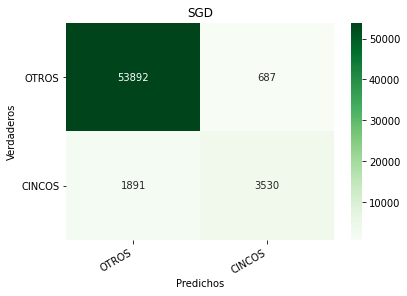

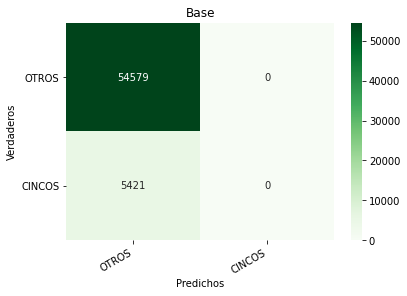

In [ ]:
import seaborn as sns
import pandas as pd
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Verdaderos')
  plt.xlabel('Predichos');
clases = ('OTROS','CINCOS')

df_cm = pd.DataFrame(cm, index=clases, columns=clases)
df_base_cm = pd.DataFrame(cm_base, index=clases, columns=clases)
plt.figure()
show_confusion_matrix(df_cm)
plt.title('SGD')
plt.figure()
show_confusion_matrix(df_base_cm)
plt.title('Base')

Ahora tengo una mejor idea de lo que esta pasando con el modelo que arme inicialmente.

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report 
precision = precision_score(y_train_5, y_train_pred) 
recall = recall_score(y_train_5, y_train_pred)
print(precision) #0.83
print(recall) #0.65
reporte = classification_report(y_train_5, y_train_pred, target_names=clases)
reporte_base = classification_report(y_train_5, y_train_pred_base, target_names=clases)
print(reporte)
print(reporte_base)

0.8370879772350012
0.6511713705958311
              precision    recall  f1-score   support

       OTROS       0.97      0.99      0.98     54579
      CINCOS       0.84      0.65      0.73      5421

    accuracy                           0.96     60000
   macro avg       0.90      0.82      0.85     60000
weighted avg       0.95      0.96      0.95     60000

              precision    recall  f1-score   support

       OTROS       0.91      1.00      0.95     54579
      CINCOS       0.00      0.00      0.00      5421

    accuracy                           0.91     60000
   macro avg       0.45      0.50      0.48     60000
weighted avg       0.83      0.91      0.87     60000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aca puedo ver la diferencia entre el modelo SGD y el modelo base que siempre predice "NO es 5".
Se puede ver que la diferencia esta en la precision y el recall que se obtienen para la clase "5". 
Sin embargo no me escapo de mirar ambos numeros. Quizas habria que pensar (seguro alguien ya lo hizo) una metrica que, asi como el f1 combina la precision y el recall para una clase, combine ambas clases. Quizas un promedio armonico de ambas f1.
Internamente el sistema clasificador utiliza un valor umbral para determinar si una instancia es de una clase o la otra. Mover este valor umbral permite obtener mas recall o mayor precision, pero no ambas cosas al mismo tiempo. Esto nos dice que debe existir un punto "ideal" donde maximizamos ambas metricas. 
Sklearn nos permite averiguar el valor de score arrojado para cada instancia y luego pensar nosotros donde nos gustaria poner el valor de umbral. Esto ultimo no podemos implementarlo utilizando sklearn, pero si lo primero y luego hacer nosotros la funcion que decide la clase segun el valor de score arrojado. La funcion que arroja el score para cada instancia es "decision_function".

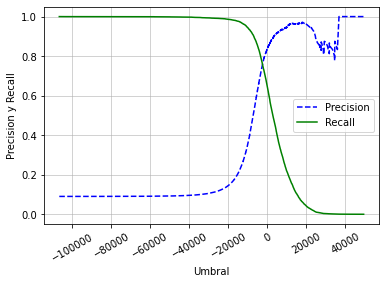

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend()
  plt.xlabel('Umbral')
  plt.ylabel('Precision y Recall')
  plt.xticks(rotation=30)
  plt.grid(axis="both", alpha=0.7)
  plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


El punto donde se encuentra la mejor relacion entre precision y recall seria aquel donde se cruzan ambas curvas. Sin embargo uno, segun el problema que este abordando, puede elegir un punto menos optimo pero que arroja mayor precision o mayor recall, segun la necesidad.

Por otro lado es interesante ver que pasa con la curva de precision (azul) que tiene un minimo local para valores muy bajos de recall. 
Dejo como tarea para el futuro evaluar esto con mas detalle.
Otro analisis que podemos hacer es el que proporciona la curva ROC. Esta curva permite ver, de forma grafica, cuan lejos esta nuestro clasificador de uno ideal. Ojo, aca habria que mirar con un poco mas de cariño este analisis y sacar algo mas jugoso que esto que estoy diciendo.

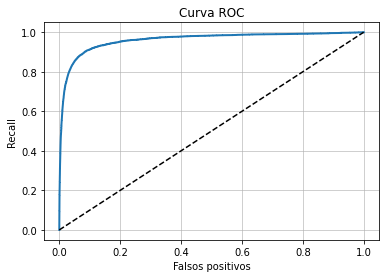

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=None)
  plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
  plt.ylabel("Recall")
  plt.xlabel("Falsos positivos")
  plt.title("Curva ROC")
  plt.grid(axis="both", alpha=0.75)
  plt.show()

plot_roc_curve(fpr, tpr)


## Clasificador multiclase

Ya probamos armar un clasificador binario para el problema, sin embargo ese no era nuestro objetivo inicial. Ahora vamos a probar armar un clasificador multiclase (10) para poder identificar cada uno de los digitos del sistema decimal. 


In [ ]:
sgd_clf_multi = SGDClassifier(random_state=42)
score = val_cruzada_score(k_folds,sgd_clf_multi,X_train,y_train)
print(score)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.87365, 0.85835, 0.8689]


In [ ]:
etiquetas = np.unique(y)
print(etiquetas)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


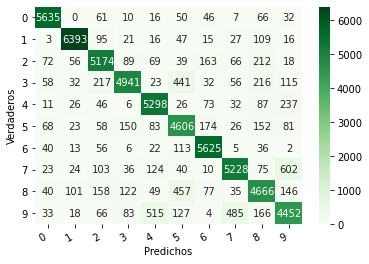

In [ ]:
y_train_pred_multi = cross_val_predict(sgd_clf_multi, X_train, y_train, cv=3)
cm_multi = confusion_matrix(y_train, y_train_pred_multi)
df_cm_multi = pd.DataFrame(cm_multi, index=etiquetas, columns=etiquetas)

plt.figure()
show_confusion_matrix(df_cm_multi)

In [ ]:
reporte = classification_report(y_train, y_train_pred_multi, target_names=etiquetas)
print(reporte)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5923
           1       0.96      0.95      0.95      6742
           2       0.86      0.87      0.86      5958
           3       0.90      0.81      0.85      6131
           4       0.85      0.91      0.88      5842
           5       0.77      0.85      0.81      5421
           6       0.90      0.95      0.93      5918
           7       0.88      0.83      0.85      6265
           8       0.81      0.80      0.80      5851
           9       0.78      0.75      0.76      5949

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000



Mirando la matriz de confusion y la precision y el recall obtenido para cada clase podemos ver que distingue entre las distintas clases de forma parecida. La clase que pero predice es la correspondiente al 9, donde vemos que tiene una precision de 0.78, o sea, que de todos los 9 que predice, el 78% lo son de verdad. Y un recall de 0.75, o sea, que encuentra el 75% de los nueves que le muestran. 
Una cosa que podemos hacer es graficar la matriz de confusion resaltando el valor de cada casillero segun su color. Esto facilita la visualizacion. Ademas podemos descartar la diagonal, que sabemos que tiene que ser lo mas parecida a 1 posible. De esta forma resaltamos los errores cometidos.

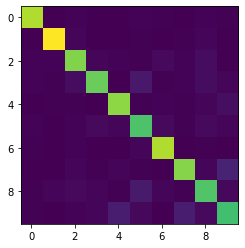

In [ ]:
plt.imshow(cm_multi)

Para visualizar el error vamos a normalizar la matriz por la cantidad de elmentos en cada clase, para poder comparar el error relativo y no el error absoluto. Esto significa que vamos a dividir cada fila (cantidad real) por la cantidad total de esa clase. Ademas, como dijimos, vamos a sacar la diagonal para resaltar los errores.


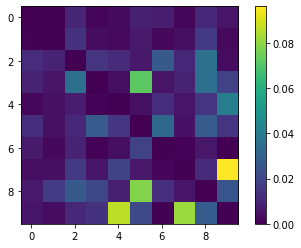

In [ ]:
row_sums = cm_multi.sum(axis=1, keepdims=True)
cm_multi_norm = cm_multi / row_sums
np.fill_diagonal(cm_multi_norm, 0) #bastante molesto que esto sea inplace
plt.imshow(cm_multi_norm)
plt.colorbar()

Se puede ver que la matriz de error indica algunas cosas que ya habiamos visto. 
La clase del 9 es una de las que mas confude. En particular muchos 9 que el sistema predice son en realidad 7, y muchos 9 de verdad el sistema los confunde con 4 y 7.

## Conjunto de TEST

Ahora que terminamos de evaluar cuan bueno o malo es el modelo podemos medir las mismas metricas sobre el conjunto de test. Los resultados que obtengamos aca son los que debemos reportar.



























































In [ ]:
sgd_clf_multi.fit(X_train, y_train)
y_test_pred_multi = sgd_clf_multi.predict(X_test)
cm_test_multi = confusion_matrix(y_test, y_test_pred_multi)
reporte_test = classification_report(y_test, y_test_pred_multi, target_names=etiquetas)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       980
           1       0.97      0.96      0.97      1135
           2       0.93      0.78      0.85      1032
           3       0.78      0.92      0.84      1010
           4       0.96      0.79      0.87       982
           5       0.86      0.79      0.83       892
           6       0.96      0.89      0.93       958
           7       0.93      0.89      0.91      1028
           8       0.65      0.90      0.75       974
           9       0.84      0.87      0.86      1009

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.88     10000



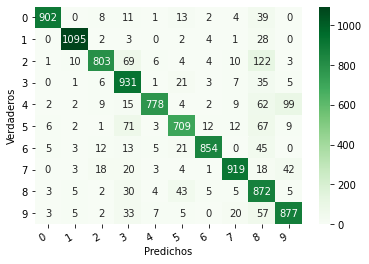

In [ ]:
print(reporte_test)
df_cm_multi_test = pd.DataFrame(cm_test_multi, index=etiquetas, columns=etiquetas)

plt.figure()
show_confusion_matrix(df_cm_multi_test)

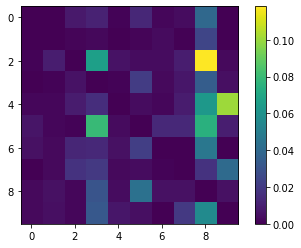

In [ ]:
row_sums = cm_test_multi.sum(axis=1, keepdims=True)
cm_multi_norm_test = cm_test_multi / row_sums
np.fill_diagonal(cm_multi_norm_test, 0) #bastante molesto que esto sea inplace
plt.imshow(cm_multi_norm_test)
plt.colorbar()

En el conjunto de test obtenemos nuevamente buenos resultados, pero el error es levemente distinto al que obtuvimos sobre el conjunto de train. Quizas habria que investigar un poco mas sobre esto, podria estar hablandonos sobre alguna diferencia en la distribucion de datos entre ambos conjuntos o algo por el estilo.

## Multi Label y Multi output

Son dos casos que agregan algo de complejidad a lo que ya vimos, pero que por ahora voy a dejar para ver mas adelante.

## COSAS PARA HACER

1. Ver clasificadores multi-label y multi-output.
2. Los ejercicios que propone el libro.
3. Probar el clasificador XGboost y algunos otros de Sklearn.